# Experiment No.1

- ByBit 4 hour chart data 
- threshold 0.75% 
- From 2020/03/25-2021/04/01 
- LightGBM 
- simple feature engineering using differencing + some technical features from ta lib 
- Used balanced class weight


In [53]:
import numpy as np 
import pandas as pd 
import os 
import random 
from transformers import *
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm 
import torch 
import torch.nn as nn
import time
import datetime
from pytorch_tabnet.tab_model import TabNetClassifier , TabNetRegressor
import json
import ccxt
from datetime import datetime, timedelta 
import seaborn as sns
import requests 
import pandas_ta as ta
import matplotlib.pyplot as plt 
from lightgbm import LGBMClassifier  
from sklearn.utils.class_weight import compute_class_weight

In [32]:
import json

with open('BTC_USDT-4h.json') as f:
    d = json.load(f)
    
df = pd.DataFrame(d)
df = df.rename(columns={0:"timestamp",
                        1:"open",
                        2:"high",
                        3:"low",
                        4:"close",
                        5:"volume"})

def process(df): 
    bybit = ccxt.bybit() 
    dates = df['timestamp'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = bybit.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'timestamp'})
    return df

df = process(df)

hours = []
days = [] 
months = [] 
years = [] 
for dt in tqdm(df['datetime']):
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    years.append(year) 

df['Hours'] = hours
df['Days'] = days 
df['Months'] = months 
df['Years'] = years 

df.tail(3)

100%|██████████| 4424/4424 [00:02<00:00, 1778.17it/s]


,open,high,low,close,volume,datetime,Hours,Days,Months,Years
4421,44580.0,45085.0,44535.5,44998.0,10953.692,2022-04-01 04:00:00,4,1,4,2022
4422,44998.0,45300.0,44955.0,45050.0,9896.384,2022-04-01 08:00:00,8,1,4,2022
4423,45050.0,46697.0,44650.0,46500.0,33075.924,2022-04-01 12:00:00,12,1,4,2022


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

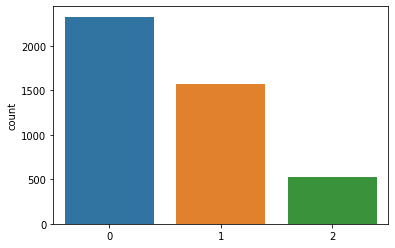

In [33]:
targets = [] 
close = df['open'].values 
high = df['high'].values 
low = df['low'].values 

threshold = 0.0075 

for i in range(close.shape[0]-1):
    high_volatility = (high[i+1]-close[i]) / close[i] 
    low_volatility = (low[i+1]-close[i]) / close[i] 
    if high_volatility >= threshold:
        targets.append(0) 
    elif low_volatility <= -threshold:
        targets.append(1) 
    else:
        targets.append(2) # do not trade 
        
        
sns.countplot(targets) 

In [34]:
targets.append(None) 

df['Targets'] = targets 

df.tail()

,open,high,low,close,volume,datetime,Hours,Days,Months,Years,Targets
4419,45590.5,45854.0,45110.0,45511.0,9912.465,2022-03-31 20:00:00,20,31,3,2022,1.0
4420,45511.0,45639.0,44202.0,44580.0,29709.921,2022-04-01 00:00:00,0,1,4,2022,1.0
4421,44580.0,45085.0,44535.5,44998.0,10953.692,2022-04-01 04:00:00,4,1,4,2022,0.0
4422,44998.0,45300.0,44955.0,45050.0,9896.384,2022-04-01 08:00:00,8,1,4,2022,0.0
4423,45050.0,46697.0,44650.0,46500.0,33075.924,2022-04-01 12:00:00,12,1,4,2022,NaN


In [36]:
print("=== Feature Engineering ===")

# add rvi 
df['RVI'] = df.ta.rvi(lookahead=False) 

# inertia 
df['inertia'] = df.ta.inertia(lookahead=False) 

for l in range(1,24): 
    for col in ['open','high','low','close','volume']: 
        val = df[col].values 
        val_ret = [None for _ in range(l)] 
        for i in range(l, len(val)):
            if val[i-l] == 0:
                ret = 1
            else:
                ret = val[i] / val[i-l] 
            val_ret.append(ret) 
        df['{}_change_{}'.format(col, l)] = val_ret 

# ebsw 
df['ebsw'] = df.ta.ebsw() 

# rsi
df['RSI'] = df.ta.rsi() 

# rsx 
df['RSX'] = df.ta.rsx() 
 
# chaikin money flow 
df['cmf'] = df.ta.cmf() 

# holt-winter moving average  
hwma = df.ta.hwma(lookahead=False).values 
close = df['close'].values  
hwma_ret = [None] 
for i in range(1, len(close)): 
    ret = hwma[i] / close[i-1] 
    hwma_ret.append(ret) 
df['hwma_ret'] = hwma_ret

# fibonacci's weighted moving average 
df['fwma'] = df.ta.fwma(lookahead=False).values 

# add average directional movement index  
df = pd.concat([df, df.ta.adx(lookahead=False)], axis=1)

# add ultimate oscillator 
df['uo'] = df.ta.uo() 

# moving average convergence divergence
df = pd.concat([df, df.ta.macd(lookahead=False)], axis = 1) 

# bollinger bands 
df = pd.concat([df, df.ta.bbands(lookahead=False)], axis=1) 

# exponential moving averages 
df['EMA10'] = df.ta.ema(length=10)
df['EMA30'] = df.ta.ema(length=30)
df['EMA60'] = df.ta.ema(length=60) 

df = df.dropna()  
df = df.drop(columns={'datetime'})

=== Feature Engineering ===


In [38]:
train_size = int(df.shape[0]*0.9) 
train_df = df[:train_size] 
test_df = df[train_size:] 

val_size = int(df.shape[0]*0.05) 
val_df = test_df[:val_size] 
test_df = test_df[val_size:] 

train_df.shape, val_df.shape, test_df.shape

((3927, 148), (218, 148), (219, 148))

In [39]:
input_columns = [] 
for col in train_df.columns:
    if col != 'Targets':
        input_columns.append(col) 
        
X_train = train_df[input_columns].values  
Y_train = train_df['Targets'].values

X_val = val_df[input_columns].values 
Y_val = val_df['Targets'].values 

X_test = test_df[input_columns].values 
Y_test = test_df['Targets'].values 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape 

((3927, 147), (3927,), (218, 147), (218,), (219, 147), (219,))

In [44]:
lgb = LGBMClassifier(n_estimators = 3000,
                     class_weight="balanced") 

lgb.fit(X_train, 
        Y_train, 
        eval_metric="multi_logloss", 
        eval_set=[(X_val, Y_val)]) 

[1]	valid_0's multi_logloss: 1.00017
[2]	valid_0's multi_logloss: 0.921816
[3]	valid_0's multi_logloss: 0.859562
[4]	valid_0's multi_logloss: 0.814126
[5]	valid_0's multi_logloss: 0.771743
[6]	valid_0's multi_logloss: 0.738083
[7]	valid_0's multi_logloss: 0.710294
[8]	valid_0's multi_logloss: 0.686674
[9]	valid_0's multi_logloss: 0.667278
[10]	valid_0's multi_logloss: 0.650133
[11]	valid_0's multi_logloss: 0.637481
[12]	valid_0's multi_logloss: 0.623696
[13]	valid_0's multi_logloss: 0.61373
[14]	valid_0's multi_logloss: 0.605599
[15]	valid_0's multi_logloss: 0.600561
[16]	valid_0's multi_logloss: 0.594464
[17]	valid_0's multi_logloss: 0.590322
[18]	valid_0's multi_logloss: 0.585474
[19]	valid_0's multi_logloss: 0.581704
[20]	valid_0's multi_logloss: 0.576331
[21]	valid_0's multi_logloss: 0.576012
[22]	valid_0's multi_logloss: 0.574209
[23]	valid_0's multi_logloss: 0.570699
[24]	valid_0's multi_logloss: 0.567895
[25]	valid_0's multi_logloss: 0.567341
[26]	valid_0's multi_logloss: 0.5687

[230]	valid_0's multi_logloss: 0.984418
[231]	valid_0's multi_logloss: 0.987122
[232]	valid_0's multi_logloss: 0.987795
[233]	valid_0's multi_logloss: 0.989919
[234]	valid_0's multi_logloss: 0.990579
[235]	valid_0's multi_logloss: 0.99562
[236]	valid_0's multi_logloss: 0.996883
[237]	valid_0's multi_logloss: 0.996911
[238]	valid_0's multi_logloss: 0.999273
[239]	valid_0's multi_logloss: 1.00151
[240]	valid_0's multi_logloss: 1.0026
[241]	valid_0's multi_logloss: 1.00436
[242]	valid_0's multi_logloss: 1.00917
[243]	valid_0's multi_logloss: 1.01108
[244]	valid_0's multi_logloss: 1.01311
[245]	valid_0's multi_logloss: 1.01549
[246]	valid_0's multi_logloss: 1.01562
[247]	valid_0's multi_logloss: 1.01621
[248]	valid_0's multi_logloss: 1.01709
[249]	valid_0's multi_logloss: 1.01917
[250]	valid_0's multi_logloss: 1.0207
[251]	valid_0's multi_logloss: 1.02259
[252]	valid_0's multi_logloss: 1.02367
[253]	valid_0's multi_logloss: 1.02492
[254]	valid_0's multi_logloss: 1.02714
[255]	valid_0's mul

[461]	valid_0's multi_logloss: 1.459
[462]	valid_0's multi_logloss: 1.46006
[463]	valid_0's multi_logloss: 1.46014
[464]	valid_0's multi_logloss: 1.46306
[465]	valid_0's multi_logloss: 1.46271
[466]	valid_0's multi_logloss: 1.46439
[467]	valid_0's multi_logloss: 1.46461
[468]	valid_0's multi_logloss: 1.46599
[469]	valid_0's multi_logloss: 1.46674
[470]	valid_0's multi_logloss: 1.46627
[471]	valid_0's multi_logloss: 1.4665
[472]	valid_0's multi_logloss: 1.46684
[473]	valid_0's multi_logloss: 1.47029
[474]	valid_0's multi_logloss: 1.47103
[475]	valid_0's multi_logloss: 1.47359
[476]	valid_0's multi_logloss: 1.47537
[477]	valid_0's multi_logloss: 1.47834
[478]	valid_0's multi_logloss: 1.47972
[479]	valid_0's multi_logloss: 1.48083
[480]	valid_0's multi_logloss: 1.48271
[481]	valid_0's multi_logloss: 1.48625
[482]	valid_0's multi_logloss: 1.48934
[483]	valid_0's multi_logloss: 1.49022
[484]	valid_0's multi_logloss: 1.49122
[485]	valid_0's multi_logloss: 1.49288
[486]	valid_0's multi_loglos

[708]	valid_0's multi_logloss: 1.62356
[709]	valid_0's multi_logloss: 1.62386
[710]	valid_0's multi_logloss: 1.62392
[711]	valid_0's multi_logloss: 1.62501
[712]	valid_0's multi_logloss: 1.62544
[713]	valid_0's multi_logloss: 1.6254
[714]	valid_0's multi_logloss: 1.62503
[715]	valid_0's multi_logloss: 1.62623
[716]	valid_0's multi_logloss: 1.62631
[717]	valid_0's multi_logloss: 1.62604
[718]	valid_0's multi_logloss: 1.62612
[719]	valid_0's multi_logloss: 1.62523
[720]	valid_0's multi_logloss: 1.62605
[721]	valid_0's multi_logloss: 1.62589
[722]	valid_0's multi_logloss: 1.62608
[723]	valid_0's multi_logloss: 1.62626
[724]	valid_0's multi_logloss: 1.62715
[725]	valid_0's multi_logloss: 1.62801
[726]	valid_0's multi_logloss: 1.62794
[727]	valid_0's multi_logloss: 1.62785
[728]	valid_0's multi_logloss: 1.62968
[729]	valid_0's multi_logloss: 1.63007
[730]	valid_0's multi_logloss: 1.62958
[731]	valid_0's multi_logloss: 1.63002
[732]	valid_0's multi_logloss: 1.62919
[733]	valid_0's multi_logl

[926]	valid_0's multi_logloss: 1.67407
[927]	valid_0's multi_logloss: 1.67493
[928]	valid_0's multi_logloss: 1.67492
[929]	valid_0's multi_logloss: 1.67479
[930]	valid_0's multi_logloss: 1.67486
[931]	valid_0's multi_logloss: 1.67513
[932]	valid_0's multi_logloss: 1.67471
[933]	valid_0's multi_logloss: 1.67516
[934]	valid_0's multi_logloss: 1.67504
[935]	valid_0's multi_logloss: 1.67519
[936]	valid_0's multi_logloss: 1.67469
[937]	valid_0's multi_logloss: 1.67448
[938]	valid_0's multi_logloss: 1.67477
[939]	valid_0's multi_logloss: 1.67475
[940]	valid_0's multi_logloss: 1.67451
[941]	valid_0's multi_logloss: 1.67464
[942]	valid_0's multi_logloss: 1.67488
[943]	valid_0's multi_logloss: 1.67574
[944]	valid_0's multi_logloss: 1.67594
[945]	valid_0's multi_logloss: 1.67603
[946]	valid_0's multi_logloss: 1.67612
[947]	valid_0's multi_logloss: 1.67628
[948]	valid_0's multi_logloss: 1.67647
[949]	valid_0's multi_logloss: 1.67623
[950]	valid_0's multi_logloss: 1.6764
[951]	valid_0's multi_logl

[1164]	valid_0's multi_logloss: 1.70295
[1165]	valid_0's multi_logloss: 1.70323
[1166]	valid_0's multi_logloss: 1.70323
[1167]	valid_0's multi_logloss: 1.70352
[1168]	valid_0's multi_logloss: 1.70378
[1169]	valid_0's multi_logloss: 1.70424
[1170]	valid_0's multi_logloss: 1.70392
[1171]	valid_0's multi_logloss: 1.70412
[1172]	valid_0's multi_logloss: 1.70433
[1173]	valid_0's multi_logloss: 1.70435
[1174]	valid_0's multi_logloss: 1.70458
[1175]	valid_0's multi_logloss: 1.70488
[1176]	valid_0's multi_logloss: 1.70493
[1177]	valid_0's multi_logloss: 1.70512
[1178]	valid_0's multi_logloss: 1.70488
[1179]	valid_0's multi_logloss: 1.70504
[1180]	valid_0's multi_logloss: 1.70551
[1181]	valid_0's multi_logloss: 1.70539
[1182]	valid_0's multi_logloss: 1.70518
[1183]	valid_0's multi_logloss: 1.70483
[1184]	valid_0's multi_logloss: 1.70516
[1185]	valid_0's multi_logloss: 1.70528
[1186]	valid_0's multi_logloss: 1.70551
[1187]	valid_0's multi_logloss: 1.70527
[1188]	valid_0's multi_logloss: 1.70529


[1376]	valid_0's multi_logloss: 1.72256
[1377]	valid_0's multi_logloss: 1.72254
[1378]	valid_0's multi_logloss: 1.72227
[1379]	valid_0's multi_logloss: 1.72243
[1380]	valid_0's multi_logloss: 1.72211
[1381]	valid_0's multi_logloss: 1.72191
[1382]	valid_0's multi_logloss: 1.72193
[1383]	valid_0's multi_logloss: 1.72175
[1384]	valid_0's multi_logloss: 1.72139
[1385]	valid_0's multi_logloss: 1.72172
[1386]	valid_0's multi_logloss: 1.72127
[1387]	valid_0's multi_logloss: 1.72125
[1388]	valid_0's multi_logloss: 1.72135
[1389]	valid_0's multi_logloss: 1.72134
[1390]	valid_0's multi_logloss: 1.72179
[1391]	valid_0's multi_logloss: 1.72192
[1392]	valid_0's multi_logloss: 1.72217
[1393]	valid_0's multi_logloss: 1.72204
[1394]	valid_0's multi_logloss: 1.72204
[1395]	valid_0's multi_logloss: 1.72181
[1396]	valid_0's multi_logloss: 1.72196
[1397]	valid_0's multi_logloss: 1.72182
[1398]	valid_0's multi_logloss: 1.72207
[1399]	valid_0's multi_logloss: 1.72203
[1400]	valid_0's multi_logloss: 1.7219
[

[1668]	valid_0's multi_logloss: 1.73874
[1669]	valid_0's multi_logloss: 1.73881
[1670]	valid_0's multi_logloss: 1.7388
[1671]	valid_0's multi_logloss: 1.73869
[1672]	valid_0's multi_logloss: 1.73914
[1673]	valid_0's multi_logloss: 1.73922
[1674]	valid_0's multi_logloss: 1.73926
[1675]	valid_0's multi_logloss: 1.73909
[1676]	valid_0's multi_logloss: 1.73897
[1677]	valid_0's multi_logloss: 1.73869
[1678]	valid_0's multi_logloss: 1.73861
[1679]	valid_0's multi_logloss: 1.73874
[1680]	valid_0's multi_logloss: 1.73837
[1681]	valid_0's multi_logloss: 1.7384
[1682]	valid_0's multi_logloss: 1.73863
[1683]	valid_0's multi_logloss: 1.73847
[1684]	valid_0's multi_logloss: 1.73873
[1685]	valid_0's multi_logloss: 1.73888
[1686]	valid_0's multi_logloss: 1.73889
[1687]	valid_0's multi_logloss: 1.73951
[1688]	valid_0's multi_logloss: 1.73971
[1689]	valid_0's multi_logloss: 1.73983
[1690]	valid_0's multi_logloss: 1.73988
[1691]	valid_0's multi_logloss: 1.73984
[1692]	valid_0's multi_logloss: 1.74003
[1

[1921]	valid_0's multi_logloss: 1.75184
[1922]	valid_0's multi_logloss: 1.75187
[1923]	valid_0's multi_logloss: 1.75212
[1924]	valid_0's multi_logloss: 1.7522
[1925]	valid_0's multi_logloss: 1.75215
[1926]	valid_0's multi_logloss: 1.75232
[1927]	valid_0's multi_logloss: 1.75241
[1928]	valid_0's multi_logloss: 1.7527
[1929]	valid_0's multi_logloss: 1.75269
[1930]	valid_0's multi_logloss: 1.75268
[1931]	valid_0's multi_logloss: 1.7525
[1932]	valid_0's multi_logloss: 1.75267
[1933]	valid_0's multi_logloss: 1.7527
[1934]	valid_0's multi_logloss: 1.75313
[1935]	valid_0's multi_logloss: 1.75316
[1936]	valid_0's multi_logloss: 1.7529
[1937]	valid_0's multi_logloss: 1.75294
[1938]	valid_0's multi_logloss: 1.75318
[1939]	valid_0's multi_logloss: 1.75355
[1940]	valid_0's multi_logloss: 1.75347
[1941]	valid_0's multi_logloss: 1.75347
[1942]	valid_0's multi_logloss: 1.75363
[1943]	valid_0's multi_logloss: 1.75391
[1944]	valid_0's multi_logloss: 1.75395
[1945]	valid_0's multi_logloss: 1.75408
[1946

[2171]	valid_0's multi_logloss: 1.76354
[2172]	valid_0's multi_logloss: 1.76319
[2173]	valid_0's multi_logloss: 1.76339
[2174]	valid_0's multi_logloss: 1.76346
[2175]	valid_0's multi_logloss: 1.76369
[2176]	valid_0's multi_logloss: 1.76386
[2177]	valid_0's multi_logloss: 1.76377
[2178]	valid_0's multi_logloss: 1.76377
[2179]	valid_0's multi_logloss: 1.76392
[2180]	valid_0's multi_logloss: 1.76359
[2181]	valid_0's multi_logloss: 1.76348
[2182]	valid_0's multi_logloss: 1.76348
[2183]	valid_0's multi_logloss: 1.76332
[2184]	valid_0's multi_logloss: 1.76355
[2185]	valid_0's multi_logloss: 1.76356
[2186]	valid_0's multi_logloss: 1.76347
[2187]	valid_0's multi_logloss: 1.76351
[2188]	valid_0's multi_logloss: 1.76329
[2189]	valid_0's multi_logloss: 1.76352
[2190]	valid_0's multi_logloss: 1.76347
[2191]	valid_0's multi_logloss: 1.76367
[2192]	valid_0's multi_logloss: 1.76344
[2193]	valid_0's multi_logloss: 1.7633
[2194]	valid_0's multi_logloss: 1.76315
[2195]	valid_0's multi_logloss: 1.76322
[

[2381]	valid_0's multi_logloss: 1.76895
[2382]	valid_0's multi_logloss: 1.76881
[2383]	valid_0's multi_logloss: 1.76861
[2384]	valid_0's multi_logloss: 1.76851
[2385]	valid_0's multi_logloss: 1.76886
[2386]	valid_0's multi_logloss: 1.76867
[2387]	valid_0's multi_logloss: 1.76854
[2388]	valid_0's multi_logloss: 1.76865
[2389]	valid_0's multi_logloss: 1.76878
[2390]	valid_0's multi_logloss: 1.76908
[2391]	valid_0's multi_logloss: 1.76889
[2392]	valid_0's multi_logloss: 1.76906
[2393]	valid_0's multi_logloss: 1.76921
[2394]	valid_0's multi_logloss: 1.76919
[2395]	valid_0's multi_logloss: 1.76914
[2396]	valid_0's multi_logloss: 1.76921
[2397]	valid_0's multi_logloss: 1.76934
[2398]	valid_0's multi_logloss: 1.76918
[2399]	valid_0's multi_logloss: 1.76905
[2400]	valid_0's multi_logloss: 1.76925
[2401]	valid_0's multi_logloss: 1.76927
[2402]	valid_0's multi_logloss: 1.76931
[2403]	valid_0's multi_logloss: 1.76949
[2404]	valid_0's multi_logloss: 1.76932
[2405]	valid_0's multi_logloss: 1.76953


[2689]	valid_0's multi_logloss: 1.77862
[2690]	valid_0's multi_logloss: 1.77843
[2691]	valid_0's multi_logloss: 1.77846
[2692]	valid_0's multi_logloss: 1.77825
[2693]	valid_0's multi_logloss: 1.77824
[2694]	valid_0's multi_logloss: 1.77839
[2695]	valid_0's multi_logloss: 1.77836
[2696]	valid_0's multi_logloss: 1.77823
[2697]	valid_0's multi_logloss: 1.77808
[2698]	valid_0's multi_logloss: 1.77845
[2699]	valid_0's multi_logloss: 1.77849
[2700]	valid_0's multi_logloss: 1.77849
[2701]	valid_0's multi_logloss: 1.77848
[2702]	valid_0's multi_logloss: 1.77841
[2703]	valid_0's multi_logloss: 1.7786
[2704]	valid_0's multi_logloss: 1.77881
[2705]	valid_0's multi_logloss: 1.77866
[2706]	valid_0's multi_logloss: 1.77886
[2707]	valid_0's multi_logloss: 1.7788
[2708]	valid_0's multi_logloss: 1.77884
[2709]	valid_0's multi_logloss: 1.7789
[2710]	valid_0's multi_logloss: 1.7789
[2711]	valid_0's multi_logloss: 1.77906
[2712]	valid_0's multi_logloss: 1.7791
[2713]	valid_0's multi_logloss: 1.77919
[2714

[2949]	valid_0's multi_logloss: 1.78466
[2950]	valid_0's multi_logloss: 1.78459
[2951]	valid_0's multi_logloss: 1.78472
[2952]	valid_0's multi_logloss: 1.78482
[2953]	valid_0's multi_logloss: 1.78508
[2954]	valid_0's multi_logloss: 1.78523
[2955]	valid_0's multi_logloss: 1.78527
[2956]	valid_0's multi_logloss: 1.78541
[2957]	valid_0's multi_logloss: 1.78533
[2958]	valid_0's multi_logloss: 1.78543
[2959]	valid_0's multi_logloss: 1.78544
[2960]	valid_0's multi_logloss: 1.78573
[2961]	valid_0's multi_logloss: 1.7854
[2962]	valid_0's multi_logloss: 1.7855
[2963]	valid_0's multi_logloss: 1.78552
[2964]	valid_0's multi_logloss: 1.78539
[2965]	valid_0's multi_logloss: 1.78547
[2966]	valid_0's multi_logloss: 1.78555
[2967]	valid_0's multi_logloss: 1.78583
[2968]	valid_0's multi_logloss: 1.78575
[2969]	valid_0's multi_logloss: 1.78578
[2970]	valid_0's multi_logloss: 1.78597
[2971]	valid_0's multi_logloss: 1.78593
[2972]	valid_0's multi_logloss: 1.78594
[2973]	valid_0's multi_logloss: 1.78579
[2

LGBMClassifier(class_weight='balanced', n_estimators=3000)

In [45]:
import joblib
# save model
joblib.dump(lgb, 'lgb_bybit.pkl')
# load model
lgb_best = joblib.load('lgb_bybit.pkl')

In [47]:
# predict 
pred = lgb.predict(X_test)

cnt = 0
for i in range(len(Y_test)):
    if Y_test[i] == pred[i]:
        cnt += 1 
        
cnt / len(pred) * 100

68.0365296803653

In [52]:
from sklearn.metrics import f1_score

print(f1_score(Y_test, pred, average='macro'))
print(f1_score(Y_test, pred, average='micro'))
print(f1_score(Y_test, pred, average='weighted'))

0.5031972208772374
0.680365296803653
0.6533664783898591
